In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# 1. Đọc dữ liệu
df = pd.read_csv('/content/gdrive/MyDrive/Khóa luân 2024 (Nguyễn Tiến Anh QUân)/Dữ liệu/VCI.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.sort_values(by='Date', inplace=True)
data = df[['Closing Price']].values

In [ ]:
# 2. Chia dữ liệu thành train, validation, test
data_length = len(data)
train_size = int(data_length * 0.7)
val_size = int(data_length * 0.15)
train_data = data[:train_size]
val_data = data[train_size:train_size + val_size]
test_data = data[train_size + val_size:]


In [ ]:
# 3. Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_scaled = scaler.fit_transform(train_data)
val_data_scaled = scaler.transform(val_data)
test_data_scaled = scaler.transform(test_data)

In [ ]:
# 4. Chuẩn bị dữ liệu Linear Regression
def create_lr_features(data, time_steps=50):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

In [ ]:
time_steps = 50
X_train_lr, y_train_lr = create_lr_features(train_data_scaled, time_steps)
X_val_lr, y_val_lr = create_lr_features(val_data_scaled, time_steps)
X_test_lr, y_test_lr = create_lr_features(test_data_scaled, time_steps)

In [ ]:
# Huấn luyện Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_lr, y_train_lr)

LinearRegression()

In [ ]:
# Dự đoán tuyến tính (Linear Regression)
train_lr_pred = lr_model.predict(X_train_lr)
val_lr_pred = lr_model.predict(X_val_lr)
test_lr_pred = lr_model.predict(X_test_lr)

In [ ]:
# Tính phần dư (Residuals)
residuals_train = y_train_lr - train_lr_pred
residuals_val = y_val_lr - val_lr_pred
residuals_test = y_test_lr - test_lr_pred


In [ ]:
# 5. Chuẩn bị dữ liệu phần dư cho LSTM
def create_lstm_features(residuals, time_steps=50):
    X, y = [], []
    for i in range(time_steps, len(residuals)):
        X.append(residuals[i-time_steps:i])
        y.append(residuals[i])
    return np.array(X), np.array(y)

X_train_lstm, y_train_lstm = create_lstm_features(residuals_train, time_steps)
X_val_lstm, y_val_lstm = create_lstm_features(residuals_val, time_steps)
X_test_lstm, y_test_lstm = create_lstm_features(residuals_test, time_steps)

In [ ]:
# Reshape dữ liệu để phù hợp với LSTM
X_train_lstm = X_train_lstm.reshape(X_train_lstm.shape[0], X_train_lstm.shape[1], 1)
X_val_lstm = X_val_lstm.reshape(X_val_lstm.shape[0], X_val_lstm.shape[1], 1)
X_test_lstm = X_test_lstm.reshape(X_test_lstm.shape[0], X_test_lstm.shape[1], 1)

In [ ]:
# 6. Xây dựng mô hình LSTM
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(units=64))
    model.add(Dropout(0.5))
    model.add(Dense(units=1))  # Output layer
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

lstm_model = build_lstm_model((X_train_lstm.shape[1], 1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Huấn luyện LSTM
lstm_model.fit(
    X_train_lstm, y_train_lstm,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_lstm, y_val_lstm),
    verbose=1
)

Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - loss: 3.0202e-04 - val_loss: 1.3376e-04
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - loss: 3.6679e-04 - val_loss: 8.3958e-05
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - loss: 3.1893e-04 - val_loss: 7.9779e-05
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - loss: 3.1873e-04 - val_loss: 8.0667e-05
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - loss: 3.5911e-04 - val_loss: 7.9767e-05
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 2.4598e-04 - val_loss: 8.8197e-05
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 9.3606e-04 - val_loss: 9.0525e-05
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - loss: 4.3728e-04 - val_loss: 8.2941e-05
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - loss: 4.2097e-04 - val_loss: 8.0365e-05
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 6.9266e-04 - val_loss: 9.9182e-05
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 6.1

In [ ]:
# Dự đoán phần dư với LSTM
residuals_test_pred = lstm_model.predict(X_test_lstm)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step


In [ ]:
# Kết hợp Linear Regression và LSTM
test_combined_pred = test_lr_pred[time_steps:] + residuals_test_pred.flatten()

In [ ]:
# Chuyển giá trị dự đoán về dạng ban đầu
test_combined_pred = scaler.inverse_transform(test_combined_pred.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test_lr[time_steps:].reshape(-1, 1))

In [ ]:
# 7. Đánh giá mô hình
print("Linear Regression - LSTM Performance:")
print("MAE:", mean_absolute_error(y_test_actual, test_combined_pred))
print("MSE:", mean_squared_error(y_test_actual, test_combined_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test_actual, test_combined_pred)))
print("R2 Score:", r2_score(y_test_actual, test_combined_pred))

Linear Regression - LSTM Performance:
MAE: 0.8415178775893185
MSE: 1.2327242032008143
RMSE: 1.1102811370102683
R2 Score: 0.8650661713633094


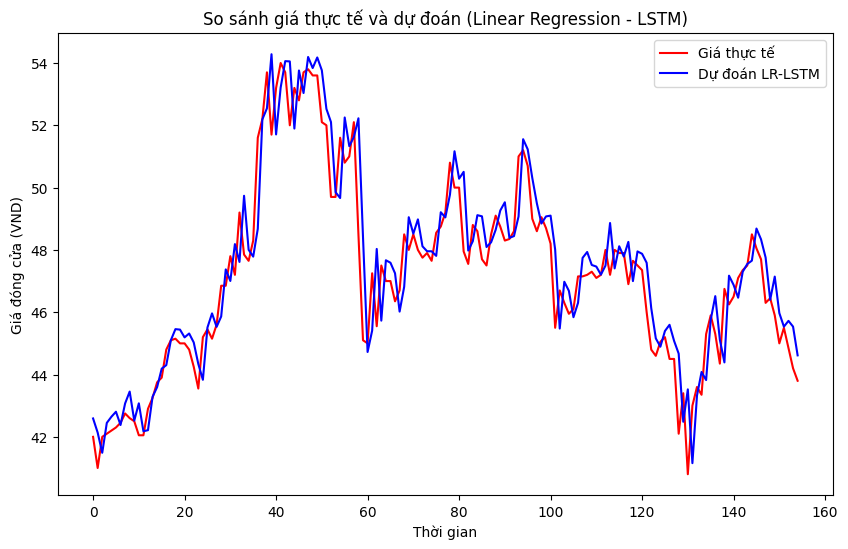

In [ ]:
# 8. Vẽ biểu đồ kết quả
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Giá thực tế', color='red')
plt.plot(test_combined_pred, label='Dự đoán LR-LSTM', color='blue')
plt.title('So sánh giá thực tế và dự đoán (Linear Regression - LSTM)')
plt.xlabel('Thời gian')
plt.ylabel('Giá đóng cửa (VND)')
plt.legend()
plt.show()